# Automatic Differentiation
:label:`sec_autograd`

Recall from :numref:`sec_calculus` 
that calculating derivatives is the crucial step
in all the optimization algorithms
that we will use to train deep networks.
While the calculations are straightforward,
working them out by hand can be tedious and error-prone, 
and these issues only grow
as our models become more complex.

Fortunately all modern deep learning frameworks
take this work off our plates
by offering *automatic differentiation*
(often shortened to *autograd*). 
As we pass data through each successive function,
the framework builds a *computational graph* 
that tracks how each value depends on others.
To calculate derivatives, 
automatic differentiation 
works backwards through this graph
applying the chain rule. 
The computational algorithm for applying the chain rule
in this fashion is called *backpropagation*.

While autograd libraries have become
a hot concern over the past decade,
they have a long history. 
In fact the earliest references to autograd
date back over half of a century :cite:`Wengert.1964`.
The core ideas behind modern backpropagation
date to a PhD thesis from 1980 :cite:`Speelpenning.1980`
and were further developed in the late 1980s :cite:`Griewank.1989`.
While backpropagation has become the default method 
for computing gradients, it is not the only option. 
For instance, the Julia programming language employs 
forward propagation :cite:`Revels.Lubin.Papamarkou.2016`. 
Before exploring methods, 
let's first master the autograd package.


In [1]:
import torch

## A Simple Function

Let's assume that we are interested
in (**differentiating the function
$y = 2\mathbf{x}^{\top}\mathbf{x}$
with respect to the column vector $\mathbf{x}$.**)
To start, we assign `x` an initial value.


In [2]:
x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

[**Before we calculate the gradient
of $y$ with respect to $\mathbf{x}$,
we need a place to store it.**]
In general, we avoid allocating new memory
every time we take a derivative 
because deep learning requires 
successively computing derivatives
with respect to the same parameters
a great many times,
and we might risk running out of memory.
Note that the gradient of a scalar-valued function
with respect to a vector $\mathbf{x}$
is vector-valued with 
the same shape as $\mathbf{x}$.


In [3]:
# Can also create x = torch.arange(4.0, requires_grad=True)
x.requires_grad_(True)
x.grad  # The gradient is None by default

(**We now calculate our function of `x` and assign the result to `y`.**)


In [4]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

[**We can now take the gradient of `y`
with respect to `x`**] by calling 
its `backward` method.
Next, we can access the gradient 
via `x`'s `grad` attribute.


In [5]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

(**We already know that the gradient of the function $y = 2\mathbf{x}^{\top}\mathbf{x}$
with respect to $\mathbf{x}$ should be $4\mathbf{x}$.**)
We can now verify that the automatic gradient computation
and the expected result are identical.


In [6]:
x.grad == 4 * x

tensor([True, True, True, True])

[**Now let's calculate 
another function of `x`
and take its gradient.**]
Note that PyTorch does not automatically 
reset the gradient buffer 
when we record a new gradient. 
Instead, the new gradient
is added to the already-stored gradient.
This behavior comes in handy
when we want to optimize the sum 
of multiple objective functions.
To reset the gradient buffer,
we can call `x.grad.zero_()` as follows:


In [7]:
x.grad.zero_()  # Reset the gradient
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

## Backward for Non-Scalar Variables

When `y` is a vector, 
the most natural representation 
of the derivative of  `y`
with respect to a vector `x` 
is a matrix called the *Jacobian*
that contains the partial derivatives
of each component of `y` 
with respect to each component of `x`.
Likewise, for higher-order `y` and `x`,
the result of differentiation could be an even higher-order tensor.

While Jacobians do show up in some
advanced machine learning techniques,
more commonly we want to sum up 
the gradients of each component of `y`
with respect to the full vector `x`,
yielding a vector of the same shape as `x`.
For example, we often have a vector 
representing the value of our loss function
calculated separately for each example among
a *batch* of training examples.
Here, we just want to (**sum up the gradients
computed individually for each example**).


Because deep learning frameworks vary 
in how they interpret gradients of
non-scalar tensors,
PyTorch takes some steps to avoid confusion.
Invoking `backward` on a non-scalar elicits an error 
unless we tell PyTorch how to reduce the object to a scalar. 
More formally, we need to provide some vector $\mathbf{v}$ 
such that `backward` will compute 
$\mathbf{v}^\top \partial_{\mathbf{x}} \mathbf{y}$ 
rather than $\partial_{\mathbf{x}} \mathbf{y}$. 
This next part may be confusing,
but for reasons that will become clear later, 
this argument (representing $\mathbf{v}$) is named `gradient`. 
For a more detailed description, see Yang Zhang's 
[Medium post](https://zhang-yang.medium.com/the-gradient-argument-in-pytorchs-backward-function-explained-by-examples-68f266950c29).


In [8]:
x.grad.zero_()
y = x * x
y.backward(gradient=torch.ones(len(y)))  # Faster: y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

## Detaching Computation

Sometimes, we wish to [**move some calculations
outside of the recorded computational graph.**]
For example, say that we use the input 
to create some auxiliary intermediate terms 
for which we do not want to compute a gradient. 
In this case, we need to *detach* 
the respective computational graph
from the final result. 
The following toy example makes this clearer: 
suppose we have `z = x * y` and `y = x * x` 
but we want to focus on the *direct* influence of `x` on `z` 
rather than the influence conveyed via `y`. 
In this case, we can create a new variable `u`
that takes the same value as `y` 
but whose *provenance* (how it was created)
has been wiped out.
Thus `u` has no ancestors in the graph
and gradients do not flow through `u` to `x`.
For example, taking the gradient of `z = x * u`
will yield the result `u`,
(not `3 * x * x` as you might have 
expected since `z = x * x * x`).


In [9]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

Note that while this procedure
detaches `y`'s ancestors
from the graph leading to `z`, 
the computational graph leading to `y` 
persists and thus we can calculate
the gradient of `y` with respect to `x`.


In [10]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

## Gradients and Python Control Flow

So far we reviewed cases where the path from input to output 
was well defined via a function such as `z = x * x * x`.
Programming offers us a lot more freedom in how we compute results. 
For instance, we can make them depend on auxiliary variables 
or condition choices on intermediate results. 
One benefit of using automatic differentiation
is that [**even if**] building the computational graph of 
(**a function required passing through a maze of Python control flow**)
(e.g., conditionals, loops, and arbitrary function calls),
(**we can still calculate the gradient of the resulting variable.**)
To illustrate this, consider the following code snippet where 
the number of iterations of the `while` loop
and the evaluation of the `if` statement
both depend on the value of the input `a`.


In [11]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

Below, we call this function, passing in a random value, as input.
Since the input is a random variable, 
we do not know what form 
the computational graph will take.
However, whenever we execute `f(a)` 
on a specific input, we realize 
a specific computational graph
and can subsequently run `backward`.


In [12]:
a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()

Even though our function `f` is, for demonstration purposes, a bit contrived,
its dependence on the input is quite simple: 
it is a *linear* function of `a` 
with piecewise defined scale. 
As such, `f(a) / a` is a vector of constant entries 
and, moreover, `f(a) / a` needs to match 
the gradient of `f(a)` with respect to `a`.


In [13]:
a.grad == d / a

tensor(True)

In [19]:
a = torch.arange(5, dtype=float)

In [20]:
d = f(a)
d

tensor([   0.,  256.,  512.,  768., 1024.], dtype=torch.float64)

In [21]:
d.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

Dynamic control flow is very common in deep learning. 
For instance, when processing text, the computational graph
depends on the length of the input. 
In these cases, automatic differentiation 
becomes vital for statistical modeling 
since it is impossible to compute the gradient *a priori*. 

## Discussion

You have now gotten a taste of the power of automatic differentiation. 
The development of libraries for calculating derivatives
both automatically and efficiently 
has been a massive productivity booster
for deep learning practitioners,
liberating them so they can focus on less menial.
Moreover, autograd lets us design massive models
for which pen and paper gradient computations 
would be prohibitively time consuming.
Interestingly, while we use autograd to *optimize* models
(in a statistical sense)
the *optimization* of autograd libraries themselves
(in a computational sense)
is a rich subject
of vital interest to framework designers.
Here, tools from compilers and graph manipulation 
are leveraged to compute results 
in the most expedient and memory-efficient manner. 

For now, try to remember these basics: (i) attach gradients to those variables with respect to which we desire derivatives; (ii) record the computation of the target value; (iii) execute the backpropagation function; and  (iv) access the resulting gradient.


## Exercises

1. Why is the second derivative much more expensive to compute than the first derivative?
1. After running the function for backpropagation, immediately run it again and see what happens. Investigate.
1. In the control flow example where we calculate the derivative of `d` with respect to `a`, what would happen if we changed the variable `a` to a random vector or a matrix? At this point, the result of the calculation `f(a)` is no longer a scalar. What happens to the result? How do we analyze this?
1. Let $f(x) = \sin(x)$. Plot the graph of $f$ and of its derivative $f'$. Do not exploit the fact that $f'(x) = \cos(x)$ but rather use automatic differentiation to get the result. 
1. Let $f(x) = ((\log x^2) \cdot \sin x) + x^{-1}$. Write out a dependency graph tracing results from $x$ to $f(x)$. 
1. Use the chain rule to compute the derivative $\frac{df}{dx}$ of the aforementioned function, placing each term on the dependency graph that you constructed previously. 
1. Given the graph and the intermediate derivative results, you have a number of options when computing the gradient. Evaluate the result once starting from $x$ to $f$ and once from $f$ tracing back to $x$. The path from $x$ to $f$ is commonly known as *forward differentiation*, whereas the path from $f$ to $x$ is known as backward differentiation. 
1. When might you want to use forward, and when backward, differentiation? Hint: consider the amount of intermediate data needed, the ability to parallelize steps, and the size of matrices and vectors involved.


[Discussions](https://discuss.d2l.ai/t/35)


#### 1. Why is the second derivative much more expensive to compute than the first derivative?

##### Answeis:

Computing the second derivative is much more expensive than the first derivative for several reasons:

1. **Computational complexity**: The second derivative requires differentiating the first derivative, essentially doubling the computational work. If the first derivative has complexity O(n), the second derivative will typically have complexity O(n²).

2. **Memory requirements with automatic differentiation**: In automatic differentiation (autograd) systems:
   - For first derivatives, the system needs to store the computational graph and intermediate values from the forward pass.
   - For second derivatives, the system needs to build and store a new computational graph for the gradient of the gradient, leading to much higher memory requirements.

3. **Implementation specifics**: As the answer mentions, autograd typically only stores values on leaf nodes and the previous computation. When computing second derivatives, this means:
   - The first backward pass creates new operations and nodes
   - A second backward pass requires building another graph on top of these new operations
   - This creates a nested differentiation structure that is inherently more complex

4. **Interdependencies**: Second derivatives often involve mixed partial derivatives with many interdependencies, increasing both computational and memory costs.

For these reasons, methods like Hessian-vector products or approximation techniques are often used when second derivatives are needed for large-scale problems.

#### 2. After running the function for backpropagation, immediately run it again and see what happens. Investigate.

##### Answers.

When we run backpropagation twice without clearing the gradients in between:

1. **Gradient accumulation**: PyTorch (and most autograd systems) accumulates gradients by default rather than overwriting them. This means that running backpropagation a second time will add to the existing gradients rather than replacing them.

2. **Doubled values**: As noted in the answer, running backpropagation twice will indeed cause gradient values to double (assuming the same computational graph). This happens because:
   - The first backward pass computes and stores gradient values
   - The second backward pass computes the same gradient values again and adds them to the existing ones
   - The result is exactly twice the original gradients

3. **Why this happens**: This behavior is by design to support:
   - Accumulated gradients across multiple batches
   - Custom gradient computation schemes
   - Distributed training scenarios

4. **Best practice**: To avoid this behavior when not intended:
   - Call `optimizer.zero_grad()` or `model.zero_grad()` before each backpropagation step
   - This clears the gradient buffers and ensures fresh gradient computation

This behavior can be a common source of bugs in deep learning code if not properly managed.

#### 3. In the control flow example where we calculate the derivative of `d` with respect to `a`, what would happen if we changed the variable `a` to a random vector or a matrix? At this point, the result of the calculation `f(a)` is no longer a scalar. What happens to the result? How do we analyze this?


##### Answer 

When we change the input variable `a` from a scalar to a vector or matrix in the given control flow example, several important changes occur:

1. The function execution itself would still work, as PyTorch operations like multiplication, norm calculation, and summation are all compatible with tensors of various dimensions. All operations would be performed element-wise or following tensor operation rules.

2. The output `d = f(a)` would now be a tensor with the same shape as the input `a` rather than a scalar.

3. The main issue arises with the backward pass. In PyTorch, calling `d.backward()` without arguments expects `d` to be a scalar. When `d` is a non-scalar tensor, this would raise an error because PyTorch doesn't know how to compute gradients with respect to multiple output elements.

To handle this situation, we have several options:

- Apply a reduction operation to convert the output to a scalar:
  ```python
  d = f(a)
  d.sum().backward()  # Sum of all elements
  # OR
  d.mean().backward()  # Mean of all elements
  ```

- Explicitly provide a gradient tensor of the same shape as the output:
  ```python
  d = f(a)
  gradient = torch.ones_like(d)  # Could be any values
  d.backward(gradient)
  ```

- Compute element-wise gradients individually:
  ```python
  for i in range(d.numel()):
      a.grad = None  # Reset gradients
      grad_tensor = torch.zeros_like(d)
      grad_tensor.view(-1)[i] = 1
      d.backward(grad_tensor, retain_graph=True)
      # Process a.grad here
  ```

From a mathematical perspective, when `d` is a tensor and `a` is a tensor, computing the gradient creates a Jacobian tensor. For example, if `a` has shape [a₁, a₂, ..., aₘ] and `d` has shape [d₁, d₂, ..., dₙ], the complete Jacobian would have shape [d₁, d₂, ..., dₙ, a₁, a₂, ..., aₘ]. Since PyTorch's automatic differentiation is primarily designed for scalar outputs, we need these workarounds to handle vector/matrix outputs properly.

#### 4. Let $f(x) = \sin(x)$. Plot the graph of $f$ and of its derivative $f'$. Do not exploit the fact that $f'(x) = \cos(x)$ but rather use automatic differentiation to get the result. 

##### Answer 

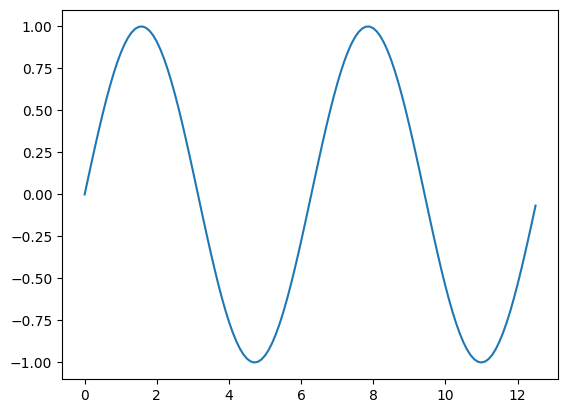

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np

x = torch.arange(0,4*np.pi,0.1)
y = torch.sin(x)

plt.plot(x,y)
plt.show()

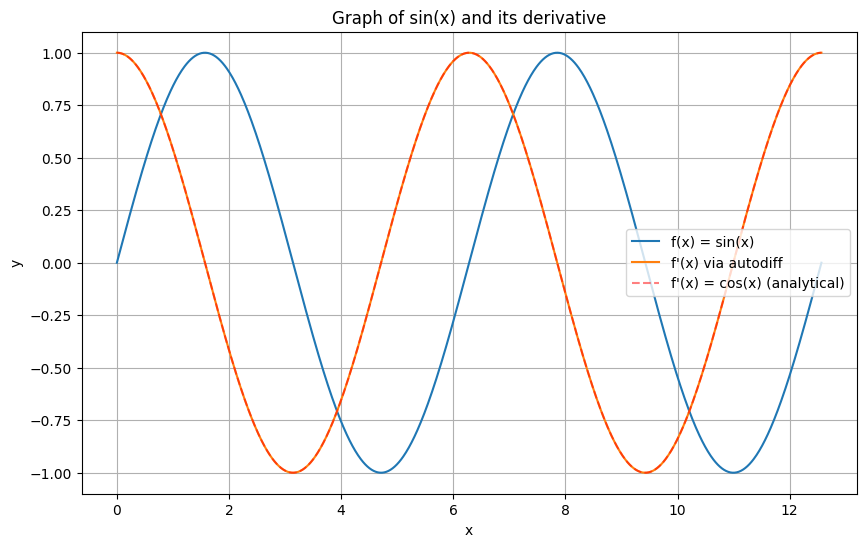

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Create a tensor with requires_grad=True to enable automatic differentiation
x = torch.linspace(0, 4*np.pi, 1000, requires_grad=True)

# Define the function f(x) = sin(x)
y = torch.sin(x)

# To compute the derivative using automatic differentiation, we need to create
# gradients for each point in y with respect to x
gradients = []

# We'll use a loop to compute the gradient at each point
for i in range(len(x)):
    # Clear previous gradients
    if x.grad is not None:
        x.grad.zero_()
    
    # Create a new computation graph for this specific point
    yi = torch.sin(x[i])
    
    # Compute the gradient dy/dx at this point
    yi.backward(retain_graph=True)
    
    # Store the gradient value
    gradients.append(x.grad[i].item())

# Convert to numpy for plotting
x_np = x.detach().numpy()
y_np = y.detach().numpy()
gradients = np.array(gradients)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x_np, y_np, label='f(x) = sin(x)')
plt.plot(x_np, gradients, label="f'(x) via autodiff")

# Optional: Plot the analytical derivative for comparison
plt.plot(x_np, np.cos(x_np), 'r--', label="f'(x) = cos(x) (analytical)", alpha=0.5)

plt.title('Graph of sin(x) and its derivative')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

#### 5. Let $f(x) = ((\log x^2) \cdot \sin x) + x^{-1}$. Write out a dependency graph tracing results from $x$ to $f(x)$. 

##### Answer 
x1 = x \
x2 = x**2\
x3 = sin(x1)\
x4 = log(x2)\
x5 = 1/x1 \
x6 = x3*x4\
x7 = x6 + x5\
f(x) = x7

#### 6. Use the chain rule to compute the derivative $\frac{df}{dx}$ of the aforementioned function, placing each term on the dependency graph that you constructed previously. 

##### Answer 

df/dx = dx7/dx = dx6/dx + dx5/dx

dx5/dx = d(1/x)/dx = -1/x² = -1/x1²

dx6/dx = d(x3*x4)/dx = x3*dx4/dx + x4*dx3/dx

dx3/dx = d(sin(x))/dx = cos(x)

dx4/dx = d(log(x²))/dx = (1/x²)·d(x²)/dx = (1/x²)·2x = 2/x

dx6/dx = x3*(2/x) + x4*cos(x) = 2*sin(x)/x + log(

df/dx = dx6/dx + dx5/dx = 2*sin(x)/x + log(x²)*cos(x) - 1/x²

df/dx = 2*sin(x)/x + log(x²)*cos(x) - 1/x²x²)*cos(x)

#### 7. Given the graph and the intermediate derivative results, you have a number of options when computing the gradient. Evaluate the result once starting from $x$ to $f$ and once from $f$ tracing back to $x$. The path from $x$ to $f$ is commonly known as *forward differentiation*, whereas the path from $f$ to $x$ is known as backward differentiation. 

##### Answer 

Calculate it and you will end up with the same result more details in this blog 

https://zhang-yang.medium.com/the-gradient-argument-in-pytorchs-backward-function-explained-by-examples-68f266950c29 and https://rufflewind.com/2016-12-30/reverse-mode-automatic-differentiation

#### 8. When might you want to use forward, and when backward, differentiation? Hint: consider the amount of intermediate data needed, the ability to parallelize steps, and the size of matrices and vectors involved.

##### Answer

When more inputs than outputs, reverse mode. And vice versa. Reasoning in the blogs mentioned.